In [2]:
#!/usr/bin/env python

# All of the argument parsing is done in the `parallel.py` module.

import multiprocessing
import time
import numpy as np
import Starfish
from Starfish.model import ThetaParam, PhiParam

import os

import Starfish.grid_tools
from Starfish.spectrum import DataSpectrum, Mask, ChebyshevSpectrum
from Starfish.emulator import Emulator
from Starfish.emulator import F_bol_interp
import Starfish.constants as C
from Starfish.covariance import get_dense_C, make_k_func, make_k_func_region

from scipy.special import j1
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.linalg import cho_factor, cho_solve
from numpy.linalg import slogdet
from astropy.stats import sigma_clip

import gc
import logging

from itertools import chain
#from collections import deque
from operator import itemgetter
import yaml
import shutil
import json



Starfish.routdir = ""

# list of keys from 0 to (norders - 1)
order_keys = np.arange(1)
DataSpectra = [DataSpectrum.open(os.path.expandvars(file), orders=Starfish.data["orders"]) for file in Starfish.data["files"]]
# list of keys from 0 to (nspectra - 1) Used for indexing purposes.
spectra_keys = np.arange(len(DataSpectra))

#Instruments are provided as one per dataset
Instruments = [eval("Starfish.grid_tools." + inst)() for inst in Starfish.data["instruments"]]


logging.basicConfig(format="%(asctime)s - %(levelname)s - %(name)s -  %(message)s", filename="{}log.log".format(
    Starfish.routdir), level=logging.DEBUG, filemode="w", datefmt='%m/%d/%Y %I:%M:%S %p')

class Order:
    def __init__(self, debug=False):
        '''
        This object contains all of the variables necessary for the partial
        lnprob calculation for one echelle order. It is designed to first be
        instantiated within the main processes and then forked to other
        subprocesses. Once operating in the subprocess, the variables specific
        to the order are loaded with an `INIT` message call, which tells which key
        to initialize on in the `self.initialize()`.
        '''
        self.lnprob = -np.inf
        self.lnprob_last = -np.inf

        self.debug = debug

    def initialize(self, key):
        '''
        Initialize to the correct chunk of data (echelle order).

        :param key: (spectrum_id, order_key)
        :param type: (int, int)

        This method should only be called after all subprocess have been forked.
        '''

        self.id = key
        spectrum_id, self.order_key = self.id
        # Make sure these are ints
        self.spectrum_id = int(spectrum_id)

        self.instrument = Instruments[self.spectrum_id]
        self.dataSpectrum = DataSpectra[self.spectrum_id]
        self.wl = self.dataSpectrum.wls[self.order_key]
        self.fl = self.dataSpectrum.fls[self.order_key]
        self.sigma = self.dataSpectrum.sigmas[self.order_key]
        self.ndata = len(self.wl)
        self.mask = self.dataSpectrum.masks[self.order_key]
        self.order = int(self.dataSpectrum.orders[self.order_key])

        self.logger = logging.getLogger("{} {}".format(self.__class__.__name__, self.order))
        if self.debug:
            self.logger.setLevel(logging.DEBUG)
        else:
            self.logger.setLevel(logging.INFO)

        self.logger.info("Initializing model on Spectrum {}, order {}.".format(self.spectrum_id, self.order_key))

        self.npoly = Starfish.config["cheb_degree"]
        self.chebyshevSpectrum = ChebyshevSpectrum(self.dataSpectrum, self.order_key, npoly=self.npoly)

        # If the file exists, optionally initiliaze to the chebyshev values
        fname = Starfish.specfmt.format(self.spectrum_id, self.order) + "phi.json"
        if os.path.exists(fname):
            self.logger.debug("Loading stored Chebyshev parameters.")
            phi = PhiParam.load(fname)
            self.chebyshevSpectrum.update(phi.cheb)

        #self.resid_deque = deque(maxlen=500) #Deque that stores the last residual spectra, for averaging
        self.counter = 0

        self.emulator = Emulator.open()
        self.emulator.determine_chunk_log(self.wl)
        self.F_bol_interp = F_bol_interp(Starfish.grid_tools.HDF5Interface())

        self.pca = self.emulator.pca

        self.wl_FFT = self.pca.wl

        # The raw eigenspectra and mean flux components
        self.EIGENSPECTRA = np.vstack((self.pca.flux_mean[np.newaxis,:], self.pca.flux_std[np.newaxis,:], self.pca.eigenspectra))

        self.ss = np.fft.rfftfreq(self.pca.npix, d=self.emulator.dv)
        self.ss[0] = 0.01 # junk so we don't get a divide by zero error

        # Holders to store the convolved and resampled eigenspectra
        self.eigenspectra = np.empty((self.pca.m, self.ndata))
        self.flux_mean = np.empty((self.ndata,))
        self.flux_std = np.empty((self.ndata,))

        self.sigma_mat = self.sigma**2 * np.eye(self.ndata)
        self.mus, self.C_GP, self.data_mat = None, None, None
        self.mus2, self.C_GP2 = None, None
        #self.ff = None
        self.Omega = None
        self.Omega2 = None
        self.qq = None

        self.lnprior = 0.0 # Modified and set by NuisanceSampler.lnprob

        # self.nregions = 0
        # self.exceptions = []

        # Update the outdir based upon id
        self.noutdir = Starfish.routdir + "{}/{}/".format(self.spectrum_id, self.order)


    def lnprob_Theta(self, p):
        '''
        Update the model to the Theta parameters and then evaluate the lnprob.

        Intended to be called from the master process via the command "LNPROB".
        '''
        try:
            self.update_Theta(p)
            lnp = self.evaluate() # Also sets self.lnprob to new value
            return lnp
        except C.ModelError:
            self.logger.debug("ModelError in stellar parameters, sending back -np.inf {}".format(p))
            return -np.inf

    def evaluate(self):
        '''
        Return the lnprob using the current version of the C_GP matrix, data matrix,
        and other intermediate products.
        '''

        self.lnprob_last = self.lnprob

        X = (self.chebyshevSpectrum.k * self.flux_std * np.eye(self.ndata)).dot(self.eigenspectra.T)

        part1 = self.Omega**2 * X.dot(self.C_GP.dot(X.T))
        part2 = self.Omega2**2 * X.dot(self.C_GP2.dot(X.T))
        part3 = self.data_mat
        
        #CC = X.dot(self.C_GP.dot(X.T)) + self.data_mat
        CC = part1 + part2 + part3

        try:
            factor, flag = cho_factor(CC)
        except np.linalg.linalg.LinAlgError:
            print("Spectrum:", self.spectrum_id, "Order:", self.order)
            self.CC_debugger(CC)
            raise

        try:
            model1 = self.Omega * (self.chebyshevSpectrum.k * self.flux_mean + X.dot(self.mus))
            model2 = self.Omega2 * self.qq * (self.chebyshevSpectrum.k * self.flux_mean + X.dot(self.mus2))
            net_model = model1 + model2
            R = self.fl - net_model

            logdet = np.sum(2 * np.log((np.diag(factor))))
            self.lnprob = -0.5 * (np.dot(R, cho_solve((factor, flag), R)) + logdet)

            self.logger.debug("Evaluating lnprob={}".format(self.lnprob))
            return self.lnprob

        # To give us some debugging information about what went wrong.
        except np.linalg.linalg.LinAlgError:
            print("Spectrum:", self.spectrum_id, "Order:", self.order)
            raise

    def draw_save(self):
        '''
        Return the lnprob using the current version of the C_GP matrix, data matrix,
        and other intermediate products.
        '''

        self.lnprob_last = self.lnprob

        X = (self.chebyshevSpectrum.k * self.flux_std * np.eye(self.ndata)).dot(self.eigenspectra.T)

        model1 = self.Omega * (self.chebyshevSpectrum.k * self.flux_mean + X.dot(self.mus))
        model2 = self.Omega2 * self.qq * (self.chebyshevSpectrum.k * self.flux_mean + X.dot(self.mus2))
        net_model = model1 + model2
        model_out = net_model

        return model_out
            

    def update_Theta(self, p):
        '''
        Update the model to the current Theta parameters.

        :param p: parameters to update model to
        :type p: model.ThetaParam
        '''

        # durty HACK to get fixed logg
        # Simply fixes the middle value to be 4.29
        # Check to see if it exists, as well
        fix_logg = Starfish.config.get("fix_logg", None)
        if fix_logg is not None:
            p.grid[1] = fix_logg
        #print("grid pars are", p.grid)

        self.logger.debug("Updating Theta parameters to {}".format(p))

        # Store the current accepted values before overwriting with new proposed values.
        self.flux_mean_last = self.flux_mean.copy()
        self.flux_std_last = self.flux_std.copy()
        self.eigenspectra_last = self.eigenspectra.copy()
        self.mus_last = self.mus
        self.C_GP_last = self.C_GP

        # Local, shifted copy of wavelengths
        wl_FFT = self.wl_FFT * np.sqrt((C.c_kms + p.vz) / (C.c_kms - p.vz))

        # If vsini is less than 0.2 km/s, we might run into issues with
        # the grid spacing. Therefore skip the convolution step if we have
        # values smaller than this.
        # FFT and convolve operations
        if p.vsini < 0.0:
            raise C.ModelError("vsini must be positive")
        elif p.vsini < 0.2:
            # Skip the vsini taper due to instrumental effects
            eigenspectra_full = self.EIGENSPECTRA.copy()
        else:
            FF = np.fft.rfft(self.EIGENSPECTRA, axis=1)

            # Determine the stellar broadening kernel
            ub = 2. * np.pi * p.vsini * self.ss
            sb = j1(ub) / ub - 3 * np.cos(ub) / (2 * ub ** 2) + 3. * np.sin(ub) / (2 * ub ** 3)
            # set zeroth frequency to 1 separately (DC term)
            sb[0] = 1.

            # institute vsini taper
            FF_tap = FF * sb

            # do ifft
            eigenspectra_full = np.fft.irfft(FF_tap, self.pca.npix, axis=1)

        # Spectrum resample operations
        if min(self.wl) < min(wl_FFT) or max(self.wl) > max(wl_FFT):
            raise RuntimeError("Data wl grid ({:.2f},{:.2f}) must fit within the range of wl_FFT ({:.2f},{:.2f})".format(min(self.wl), max(self.wl), min(wl_FFT), max(wl_FFT)))

        # Take the output from the FFT operation (eigenspectra_full), and stuff them
        # into respective data products
        for lres, hres in zip(chain([self.flux_mean, self.flux_std], self.eigenspectra), eigenspectra_full):
            interp = InterpolatedUnivariateSpline(wl_FFT, hres, k=5)
            lres[:] = interp(self.wl)
            del interp

        # Helps keep memory usage low, seems like the numpy routine is slow
        # to clear allocated memory for each iteration.
        gc.collect()

        # Determine the F_bol ratio
        F_bol1 = self.F_bol_interp.interp(p.grid)
        F_bol2 = self.F_bol_interp.interp(np.append(p.teff2, p.grid[1:]))
        self.qq = F_bol2[0]/F_bol1[0]

        # Adjust flux_mean and flux_std by Omega
        #Omega = 10**p.logOmega
        #self.flux_mean *= Omega
        #self.flux_std *= Omega

        # Now update the parameters from the emulator
        # If pars are outside the grid, Emulator will raise C.ModelError
        self.emulator.params = p.grid
        self.mus, self.C_GP = self.emulator.matrix
        self.emulator.params = np.append(p.teff2, p.grid[1:])
        #self.emulator.params = np.append(6132.0, p.grid[1:])
        self.mus2, self.C_GP2 = self.emulator.matrix
        self.Omega = 10**p.logOmega
        self.Omega2 = 10**p.logOmega2



class SampleThetaPhi(Order):

    def initialize(self, key):
        # Run through the standard initialization
        super().initialize(key)

        # for now, start with white noise
        self.data_mat = self.sigma_mat.copy()
        self.data_mat_last = self.data_mat.copy()

        #Set up p0 and the independent sampler
        fname = Starfish.specfmt.format(self.spectrum_id, self.order) + "phi.json"
        phi = PhiParam.load(fname)

        # Set the regions to None, since we don't want to include them even if they
        # are there
        phi.regions = None

        #Loading file that was previously output
        # Convert PhiParam object to an array
        self.p0 = phi.toarray()

        jump = Starfish.config["Phi_jump"]
        cheb_len = (self.npoly - 1) if self.chebyshevSpectrum.fix_c0 else self.npoly
        cov_arr = np.concatenate((Starfish.config["cheb_jump"]**2 * np.ones((cheb_len,)), np.array([jump["sigAmp"], jump["logAmp"], jump["l"]])**2 ))
        cov = np.diag(cov_arr)

        def lnfunc(p):
            # Convert p array into a PhiParam object
            ind = self.npoly
            if self.chebyshevSpectrum.fix_c0:
                ind -= 1

            cheb = p[0:ind]
            sigAmp = p[ind]
            ind+=1
            logAmp = p[ind]
            ind+=1
            l = p[ind]

            par = PhiParam(self.spectrum_id, self.order, self.chebyshevSpectrum.fix_c0, cheb, sigAmp, logAmp, l)

            self.update_Phi(par)

            # sigAmp must be positive (this is effectively a prior)
            # See https://github.com/iancze/Starfish/issues/26
            if not (0.0 < sigAmp): 
                self.lnprob_last = self.lnprob
                lnp = -np.inf
                self.logger.debug("sigAmp was negative, returning -np.inf")
                self.lnprob = lnp # Same behavior as self.evaluate()
            else:
                lnp = self.evaluate()
                self.logger.debug("Evaluated Phi parameters: {} {}".format(par, lnp))

            return lnp


    def update_Phi(self, p):
        self.logger.debug("Updating nuisance parameters to {}".format(p))

        # Read off the Chebyshev parameters and update
        self.chebyshevSpectrum.update(p.cheb)

        # Check to make sure the global covariance parameters make sense
        #if p.sigAmp < 0.1:
        #   raise C.ModelError("sigAmp shouldn't be lower than 0.1, something is wrong.")

        max_r = 6.0 * p.l # [km/s]

        # Create a partial function which returns the proper element.
        k_func = make_k_func(p)

        # Store the previous data matrix in case we want to revert later
        self.data_mat_last = self.data_mat
        self.data_mat = get_dense_C(self.wl, k_func=k_func, max_r=max_r) + p.sigAmp*self.sigma_mat

/Users/gully/GitHub/Starfish/Starfish/__init__.py:16: UserWarning: Using the default config.yaml file located at /Users/gully/GitHub/Starfish/Starfish/config.yaml. This is likely NOT what you want. Please create a similar 'config.yaml' file in your current working directory.
  warnings.warn("Using the default config.yaml file located at {0}. This is likely NOT what you want. Please create a similar 'config.yaml' file in your current working directory.".format(default), UserWarning)


OSError: Unable to open file (Unable to open file: name = 'data/wasp14/wasp14-2009-06-14.hdf5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [1]:
# Run the program.

model = SampleThetaPhi(debug=True)

model.initialize((0,0))

def lnprob_all(p):
    try:
        pars1 = ThetaParam(grid=p[0:3], vz=p[3], vsini=p[4], logOmega=p[5], teff2=p[6], logOmega2=p[7])
        model.update_Theta(pars1)
        # hard code npoly=3 (for fixc0 = True with npoly=4)
        #pars2 = PhiParam(0, 0, True, p[6:9], p[9], p[10], p[11])
        pars2 = PhiParam(0, 0, True, p[8:11], p[11], p[12], p[13])
        model.update_Phi(pars2)
        draw = model.draw_save()
        return draw
    except C.ModelError:
        model.logger.debug("ModelError in stellar parameters, sending back -np.inf {}".format(p))
        return -np.inf

NameError: name 'SampleThetaPhi' is not defined

In [3]:
ws = np.load("emcee_chain.npy")

burned = ws[:, 3000:4000,:]
xs, ys, zs = burned.shape
fc = burned.reshape(xs*ys, zs)

nx, ny = fc.shape

n_draws = 200
rints = np.random.randint(0, nx, size=n_draws)

draws = []

for i in range(n_draws):
    rint = rints[i]
    t_pars = fc[rint]
    draw = lnprob_all(t_pars)
    draws.append(draw)

print("The end.")

DEBUG:SampleThetaPhi 0:Updating Theta parameters to grid:[  4.01700285e+03   3.85805162e+00   1.20206347e-01] vz:10.87647450812676 vsini:30.003576473931904 logOmega:-0.4911402270404596 Av:0.0 teff2:3103.079286331369 ff:-0.5661881646420569
DEBUG:SampleThetaPhi 0:Updating nuisance parameters to spectrum_id:0 order:0 fix_c0:True cheb:[ 0.01366272  0.03019003  0.01485069] sigAmp:0.3739475402122561 logAmp:-1.954896936445659 l:20.732055244168397 regions:None
DEBUG:SampleThetaPhi 0:Updating Theta parameters to grid:[  4.11065149e+03   3.66162124e+00  -4.83414801e-01] vz:10.467162449838561 vsini:29.01001165686489 logOmega:-0.4996467557006705 Av:0.0 teff2:3077.9353192258754 ff:-0.47331310272837435
DEBUG:SampleThetaPhi 0:Updating nuisance parameters to spectrum_id:0 order:0 fix_c0:True cheb:[ 0.00460985  0.0289165   0.0094096 ] sigAmp:0.35367974088785875 logAmp:-1.9594490829449556 l:23.012641596804688 regions:None
DEBUG:SampleThetaPhi 0:Updating Theta parameters to grid:[  4.01869988e+03   3.803

The end.


In [4]:
import json

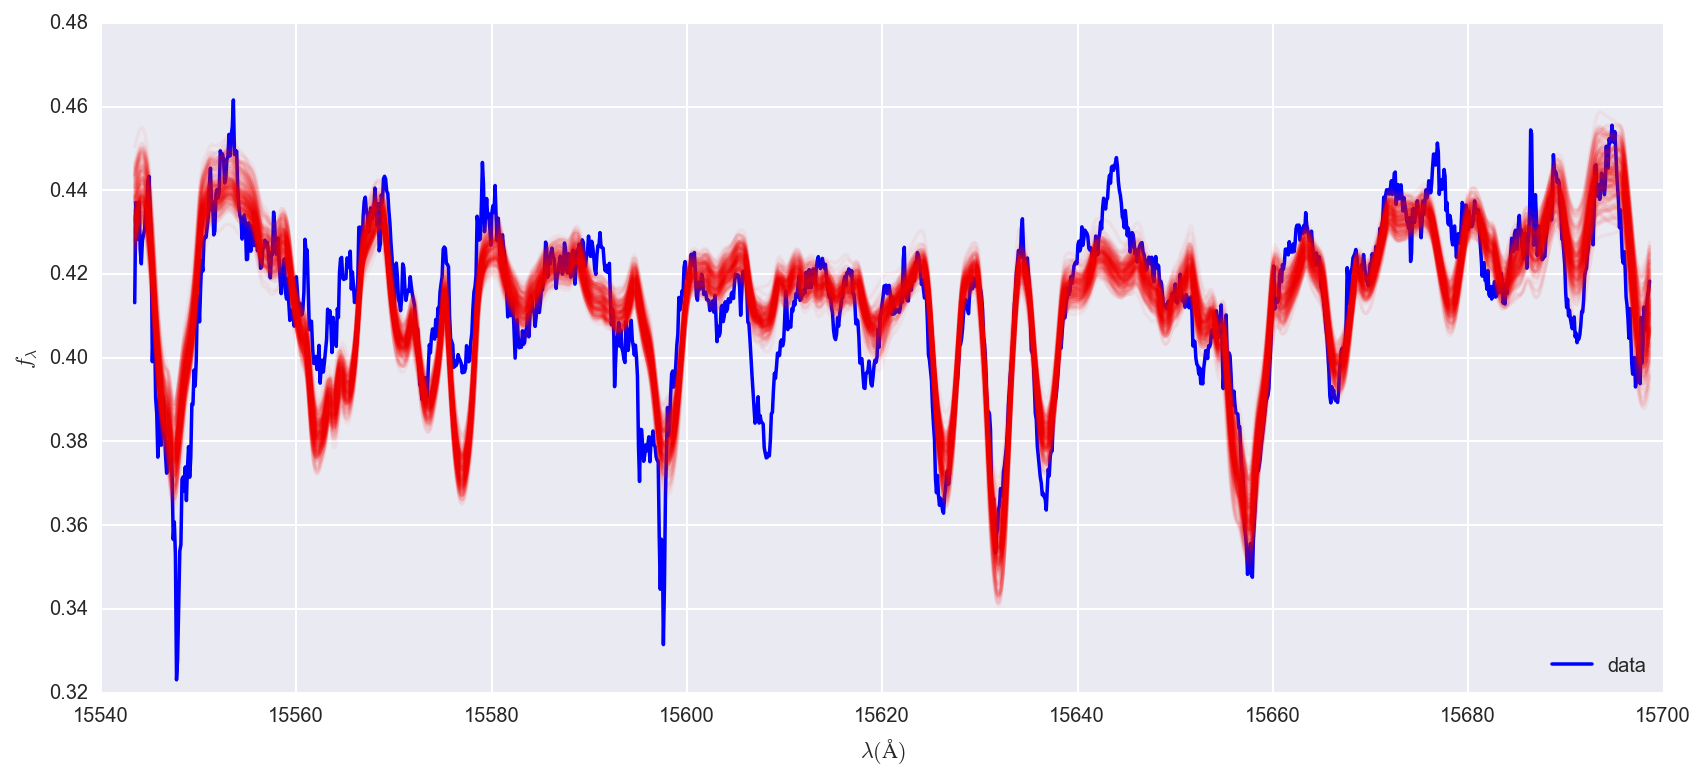

In [5]:
#Colorbrewer bands
s3 = '#fee6ce'
s2 = '#fdae6b'
s1 = '#e6550d'

f = open('s0_o0spec.json', "r")
read = json.load(f) # read is a dictionary
f.close()

wl = np.array(read["wl"])
data = np.array(read["data"])
model = np.array(read["model"])
sigma = np.array(read["sigma"])
resid = np.array(read["resid"])
spectrum_id = read["spectrum_id"]
order = read["order"]


fig = plt.figure(figsize=(14, 6))
ax = plt.axes()
ax.plot(wl, data, "b", label="data")
for i in range(n_draws):
    ax.plot(wl, draws[i], "r", alpha=0.05)
#ax.plot(wl, model, "g", label="model")

ax.set_xlabel(r"$\lambda (\AA)$")
ax.set_ylabel(r"$f_\lambda$")
ax.legend(loc="lower right")

# Animation 

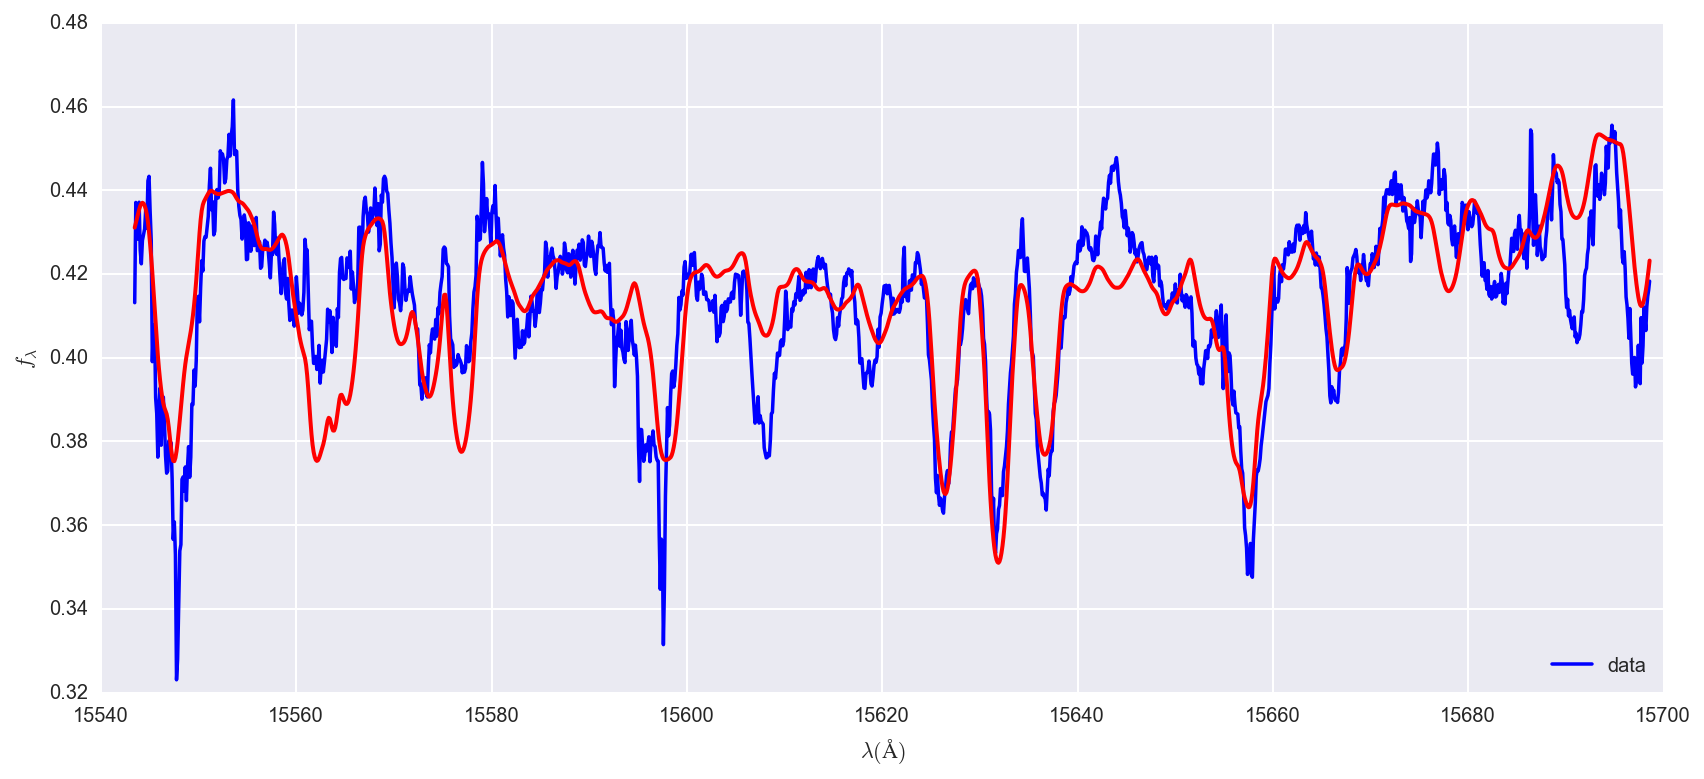

In [6]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

from matplotlib import animation


fig = plt.figure(figsize=(14, 6))
ax = plt.axes()
ax.plot(wl, data, "b", label="data")
ax.set_xlabel(r"$\lambda (\AA)$")
ax.set_ylabel(r"$f_\lambda$")
ax.legend(loc="lower right")

# First set up the figure, the axis, and the plot element we want to animate
line, = ax.plot([], [], 'r', lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    line.set_data(wl, draws[i])
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('spec_animation.mp4', fps=10, dpi=300)

plt.show()